In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

from sklearn.linear_model import LinearRegression

# Functions for Fitting Gauss to Peaks of Pictures

In [3]:
#import the pictures
def read_images_in_folder(folder_path):
    images = []
    for filename in sorted(os.listdir(folder_path), key=lambda x: int(x.split('_')[0])):
        if filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            images.append(plt.imread(image_path))
    return images

#returns the x_range of the peak
def get_range(x, pk):
    
    center = x[pk]
    
    left = center - 50
    right = center + 50
    
    if center < 49:
        left = 0
    if center > (1439-50):
        right = 1439
        
    x_range = np.arange(left, right)
        
    return x_range

#returns the number of the image of the peak
def image_of_peak(pk, n_pk):
    p = pk
    pic = -1
    while p >= 0:
        pic += 1
        p -= n_pk[pic]
    return pic

#returns at which place in the image the peak is
def peak_of_image(pk, n_pk):
    #number of peaks in total and per image
    poi = pk
    pic = image_of_peak(pk, n_pk)
    if pic == 0:
        return poi
    for i in range(pic):
        poi -= n_pk[i]
    return poi


#Define a Gaussian function
def gaussian(x, A, mu, sigma, background):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + background


def fit_gaussian(img, start_ind, end_ind):

    # Extract the subset of data for fitting
    x_data = np.arange(start_ind, end_ind)
    y_data = img[start_ind:end_ind]
        
    # Initial guess for the parameters [Amplitude, Mean, Standard Deviation]
    initial_guess = [np.max(y_data), start_ind+np.argmax(y_data), 10, 0.2]

    # Fit the Gaussian curve
    params, covariance = curve_fit(gaussian, x_data, y_data, p0=initial_guess)
    return params


def plot_peak(avgs, i, x, n_pk, pk_params, la):
    peak = i
    pic = image_of_peak(peak, n_pk)
    A, mu, sigma, background = pk_params[peak]
    
    x_range = get_range(x, peak)
        
    start_index = x_range[0]
    end_index = x_range[-1]
    
    x_data = np.arange(start_index, end_index)
    y_data = avgs[pic][start_index:end_index]
    
    # Generate fitted curve
    x_fit = np.linspace(start_index, end_index, 1000)
    y_fit = gaussian(x_fit, A, mu, sigma, background)
    
    # Plot the data on the current axis
    ax.plot(x_data, y_data, label='Data')
    ax.plot(x_fit, y_fit, label='$\mu$={:.1f}, $\sigma$={:.2f}'.format(mu, sigma))
    ax.set_title('Picture {}, Peak {}, $\lambda$ = {:.1f}nm'.format(pic+1, peak_of_image(peak, n_peaks)+1, la[peak]))
    ax.legend()


def get_peak_params(x, avgs, peak, n_peaks):
    picture = avgs[image_of_peak(peak, n_peaks)]
    
    x_range = get_range(x, peak)
    start_index = x_range[0]
    end_index = x_range[-1]
    x_observed = x[peak]

    A, mu, sigma, background = fit_gaussian(picture, start_index, end_index)
    
    return np.array([A, mu, sigma, background])



In [4]:
#observations, x values are estimates for the center of the peaks

n_peaks = np.array([1,1,1,1,1])


la = np.array([667.8,\
              587.6,\
              501.6,\
              447.1,\
              388.9])



r = np.array([-64,\
             150,\
             380,\
             520,\
             670])

x_obs = np.array([410,\
                  490,\
                  646,\
                  606,\
                  561])


In [5]:
peak_params = np.zeros((len(la), 4), dtype=float)


images = read_images_in_folder('./calibration')
averages = np.mean(images, axis = (1,3))

print(np.shape(averages))

for peak in range(len(la)):
    peak_params[peak] = get_peak_params(x_obs, averages, peak, n_peaks)    

(5, 1440)


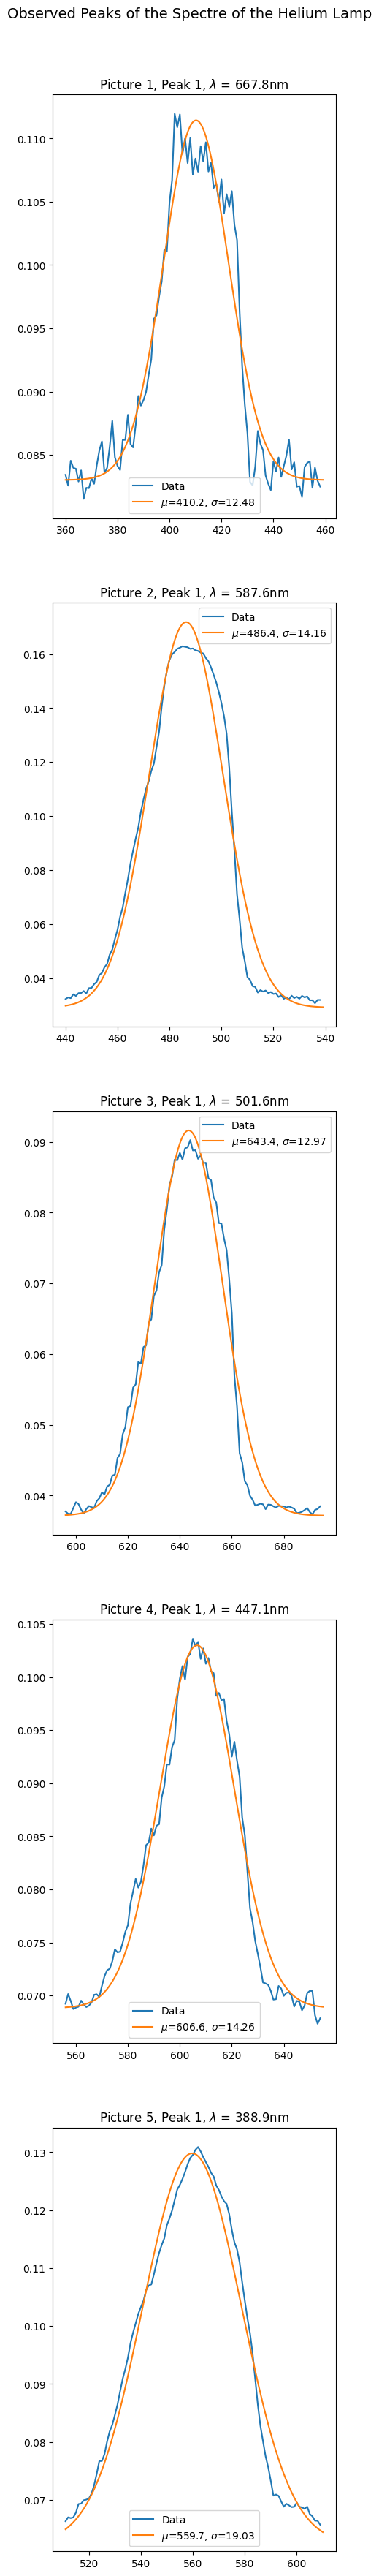

In [6]:
#plot everything
fig, axes = plt.subplots(len(images),1, figsize=(5, 40))

# Loop through the axes and plot something on each one
for i, ax in enumerate(axes.flat):
    plot_peak(averages, i, x_obs, n_peaks, peak_params, la)
    

# Adjust spacing between subplots for better layout
#plt.tight_layout()
plt.suptitle('Observed Peaks of the Spectre of the Helium Lamp', fontsize = 14)
plt.subplots_adjust(top=0.95)
plt.savefig('helium.pdf', bbox_inches='tight')
plt.show()



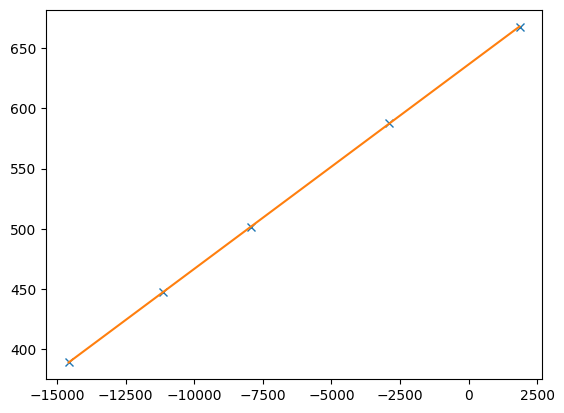

In [7]:
#data analysis

x_gauss = peak_params[:,1]


# Create a 2D array with the independent variables
X = np.column_stack((r, x_gauss))

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model
model.fit(X, la)

# Access the coefficients (slope) and intercept
coefficients = model.coef_
intercept = model.intercept_

a = coefficients[0]
b = coefficients[1]
c = intercept


#the spectrometer is now calibrated
def la_func(r,x):
    return a*r+ b*x + c


x_plt = x_obs+a/b*r
x_fit = np.linspace(np.min(x_plt), np.max(x_plt),1000)

plt.plot(x_plt, la, 'x')
plt.plot(x_fit, b*x_fit+c)

In [8]:
#3. computing g from p * dlambda = - dx * (g / f) cos(alpha_m)

s = 3.45e-6 #pixel length: cs165 cu / m
p = 1 # (order number)
alpha_m = 15/180*np.pi  #15° (angle of parabolic mirrors)
f = 0.381 #m (focal length)
#with dlambda/dx = b/s

g = p * f * b/s / np.cos(alpha_m)
print(g)
print(1e6/g) #gratings in one mm

1942.4785770337512
514.8061923684344


# Unknown Lightsource

In [8]:
unk_n_peaks = np.array([2,1,1,1,4])

unk_r = np.array([-118, -118,\
                 -90,\
                 -20,\
                 46,\
                 90, 90, 90, 90])
unk_x = np.array([1062, 1137,\
                 742,\
                 711,\
                 550,\
                 526, 659, 769, 1243])

In [9]:
unk_peak_params = np.zeros((len(unk_r), 4), dtype=float)


unk_images = read_images_in_folder('./unknown')
unk_averages = np.mean(unk_images, axis = (1,3))

print(np.shape(unk_averages))

for peak in range(len(unk_r)):
    unk_peak_params[peak] = get_peak_params(unk_x, unk_averages, peak, unk_n_peaks)   

(5, 1440)


[576.39540635 578.51734063 545.79705318 490.86787425 435.33511558
 400.57709205 404.34747555 407.4667365  420.72849411]


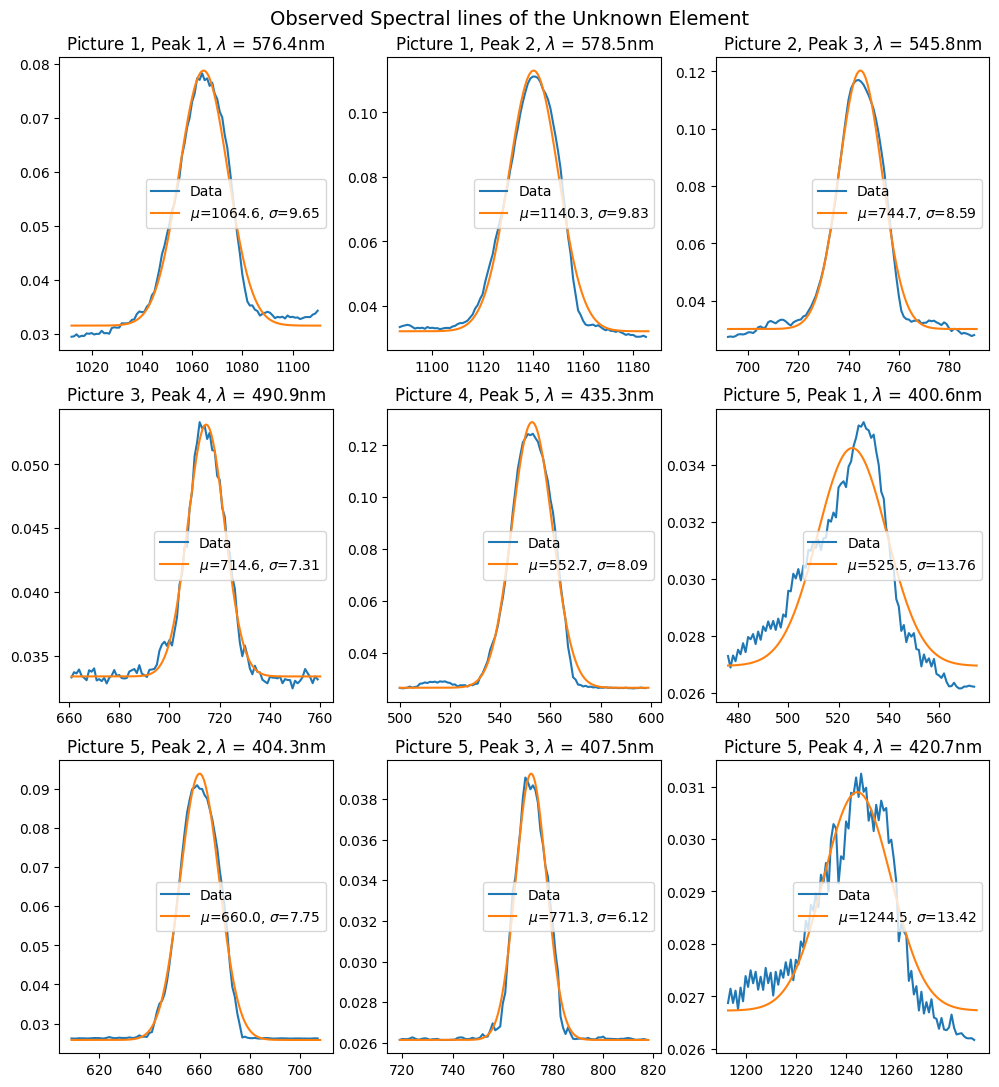

In [10]:

#plot everything
fig, axes = plt.subplots(3,3, figsize=(12, 12))

unk_x_gauss = unk_peak_params[:,1]

unk_la = la_func(unk_r, unk_x_gauss)
print(unk_la)

# Loop through the axes and plot something on each one
for i, ax in enumerate(axes.flat):
    plot_peak(unk_averages, i, unk_x, unk_n_peaks, unk_peak_params, unk_la)
    

# Adjust spacing between subplots for better layout
#plt.tight_layout()
plt.suptitle('Observed Spectral lines of the Unknown Element', fontsize = 14)
plt.subplots_adjust(top=0.94)
plt.savefig('unknown.pdf', bbox_inches='tight')
plt.show()

# Sun

In [11]:
#sun knob positions of the pixels
sun_r = np.array([60,\
                  10,\
                  -24,\
                  -66,\
                  -154,\
                  -206])


wavelength range of image: 615 - 655
40.358675365925706


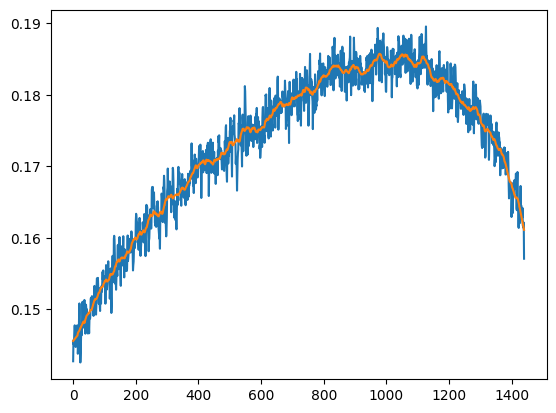

In [12]:

sun_images = read_images_in_folder('./sun')
sun_averages = np.mean(sun_images, axis = (1,3))

# Apply the Savitzky-Golay filter for smoothing
window_size = 30
order = 1
sun_averages_smooth = np.zeros((6, 1440), dtype=float)
for i in range(6):
    sun_averages_smooth[i] = savgol_filter(sun_averages[i], window_size, order)

    
    
pic = 5
lower = sun_r[pic]*a+c
higher = sun_r[pic]*a+1440*b+c
print('wavelength range of image: {:.0f} - {:.0f}'.format(lower, higher))
print(higher-lower)
plt.plot(sun_averages[pic])
plt.plot(sun_averages_smooth[pic])
plt.savefig('image{}_{:.0f}-{:.0f}.pdf'.format(pic+1,lower,higher), bbox_inches='tight')

#for peak in range(len(x_exp_img)):
#    unk_peak_params[peak] = get_peak_params(x_exp_img, sun_averages, peak, sun_n_peaks)   

In [13]:
#Define a Gaussian function with a slope
def gaussian_sun(x, A, B, mu, sigma, background):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + B*x + background


def fit_gaussian_sun(img, start_ind, end_ind, mean):

    # Extract the subset of data for fitting
    x_data = np.arange(start_ind, end_ind)
    y_data = img[start_ind:end_ind]
        
    # Initial guess for the parameters [Amplitude, Slope, Mean, Standard Deviation]
    initial_guess = [0.1, 0, mean, 10, 0.2]

    # Fit the Gaussian curve
    params, covariance = curve_fit(gaussian_sun, x_data, y_data, p0=initial_guess)
    return params





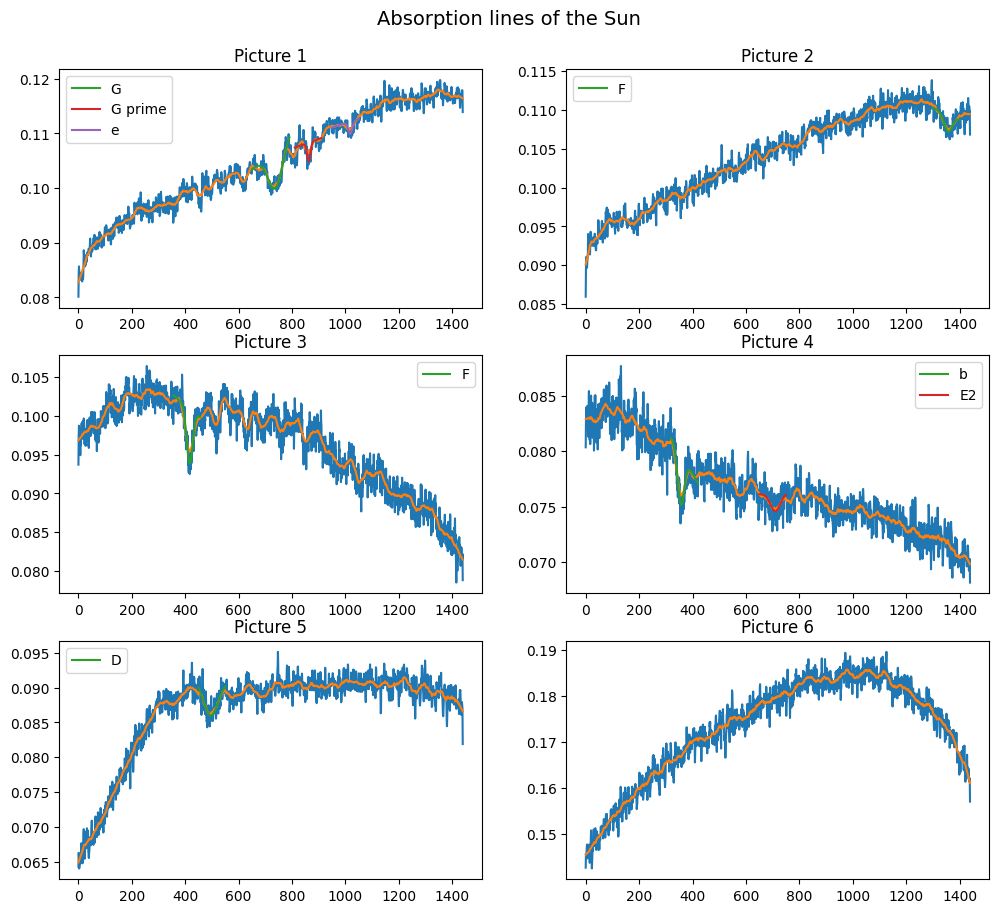

In [16]:
params = []


#creating the figure
fig, axes = plt.subplots(3,2, figsize=(12, 10))


pic = 0

pos = 720
start = pos -70
end = pos + 70
A, B, mu, sigma, background = fit_gaussian_sun(sun_averages[pic], start, end, pos)
x_dataG = np.linspace(start,end, 1000)
y_dataG = gaussian_sun(x_dataG, A, B, mu, sigma, background)
params.append([pic, sun_r[pic], mu])

pos = 860
start = pos -50
end = pos + 50
A, B, mu, sigma, background = fit_gaussian_sun(sun_averages[pic], start, end, pos)
x_dataGd = np.linspace(start,end, 1000)
y_dataGd = gaussian_sun(x_dataGd, A, B, mu, sigma, background)
params.append([pic, sun_r[pic], mu])


pos = 1000
start = pos -50
end = pos + 50
A, B, mu, sigma, background = fit_gaussian_sun(sun_averages[pic], start, end, pos)
x_datae = np.linspace(start,end, 1000)
y_datae = gaussian_sun(x_datae, A, B, mu, sigma, background)
params.append([pic, sun_r[pic], mu])


axes.flat[pic].plot(sun_averages[pic])
axes.flat[pic].plot(sun_averages_smooth[pic])
axes.flat[pic].plot(x_dataG, y_dataG, label='G')
axes.flat[pic].plot(x_dataGd, y_dataGd, label='G prime')
axes.flat[pic].plot(x_datae, y_datae, label = 'e')
axes.flat[pic].legend()
axes.flat[pic].set_title('Picture 1')



pic = 1

pos = 1350
start = pos -50
end = pos + 50
A, B, mu, sigma, background = fit_gaussian_sun(sun_averages[pic], start, end, pos)
x_dataF = np.linspace(start,end, 1000)
y_dataF = gaussian_sun(x_dataF, A, B, mu, sigma, background)
params.append([pic, sun_r[pic], mu])


axes.flat[pic].plot(sun_averages[pic])
axes.flat[pic].plot(sun_averages_smooth[pic])
axes.flat[pic].plot(x_dataF, y_dataF, label='F')
axes.flat[pic].legend()
axes.flat[pic].set_title('Picture 2')




pic = 2

pos = 406
start = pos -50
end = pos + 50
A, B, mu, sigma, background = fit_gaussian_sun(sun_averages[pic], start, end, pos)
x_dataF = np.linspace(start,end, 1000)
y_dataF = gaussian_sun(x_dataF, A, B, mu, sigma, background)
params.append([pic, sun_r[pic], mu])


axes.flat[pic].plot(sun_averages[pic])
axes.flat[pic].plot(sun_averages_smooth[pic])
axes.flat[pic].plot(x_dataF, y_dataF, label='F')
axes.flat[pic].legend()
axes.flat[pic].set_title('Picture 3')





pic = 3


pos = 370
start = pos -50
end = pos + 50
A, B, mu, sigma, background = fit_gaussian_sun(sun_averages[pic], start, end, pos)
x_datab = np.linspace(start,end, 1000)
y_datab = gaussian_sun(x_datab, A, B, mu, sigma, background)
params.append([pic, sun_r[pic], mu])


pos = 700
start = pos -50
end = pos + 50
A, B, mu, sigma, background = fit_gaussian_sun(sun_averages[pic], start, end, pos)
x_dataE = np.linspace(start,end, 1000)
y_dataE = gaussian_sun(x_dataE, A, B, mu, sigma, background)
params.append([pic, sun_r[pic], mu])




axes.flat[pic].plot(sun_averages[pic])
axes.flat[pic].plot(sun_averages_smooth[pic])
axes.flat[pic].plot(x_datab, y_datab, label='b')
axes.flat[pic].plot(x_dataE, y_dataE, label='E2')
axes.flat[pic].legend()
axes.flat[pic].set_title('Picture 4')




pic = 4

pos = 500
start = pos -50
end = pos + 50
A, B, mu, sigma, background = fit_gaussian_sun(sun_averages[pic], start, end, pos)
x_dataD = np.linspace(start,end, 1000)
y_dataD = gaussian_sun(x_dataD, A, B, mu, sigma, background)
params.append([pic, sun_r[pic], mu])


axes.flat[pic].plot(sun_averages[pic])
axes.flat[pic].plot(sun_averages_smooth[pic])
axes.flat[pic].plot(x_dataD, y_dataD, label='D')
axes.flat[pic].legend()
axes.flat[pic].set_title('Picture 5')


axes.flat[5].plot(sun_averages[5])
axes.flat[5].plot(sun_averages_smooth[5])
axes.flat[5].set_title('Picture 6')


plt.suptitle('Absorption lines of the Sun', fontsize = 14)
plt.subplots_adjust(top=0.92)
plt.savefig('sun.pdf', bbox_inches='tight')
plt.show()


In [ ]:
params = np.array(params)

la = la_func(params[:,1], params[:,2])
la = np.round(la, decimals = 1)
print(la)

In [ ]:

# Given data
data = [
    ['G', 60, 428.7, 430.8],
    ['G\'', 60, 432.1, 434.0],
    ['e', 60, 436.3, 438.4],
    ['F', 10, 488.0, 486.1],
    ['c', -24, 491.3, 495.8],
    ['b', -66, 525.4, 518.4],
    ['E2', -66, 535.0, 527.0],
    ['D', -154, 604.0, 589.6]
]

# Extract the last column into a NumPy array
last_column_array = np.array([row[3] for row in data])

# Print the NumPy array
print(last_column_array)

print(last_column_array-la)

In [17]:
print(60*a+c)
print(-154*a+c)

409.0286809893811
574.3737717240629
